In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import pickle
import sklearn
import cv2
%matplotlib inline

In [2]:
# load all the models
haar = cv2.CascadeClassifier('./model/haarcascade_frontalface_default.xml')
# pickle files
mean  = pickle.load(open('./model/mean_preprocess.pickle','rb'))
model_svm  = pickle.load(open('./model/model_svm.pickle','rb'))
model_pca  = pickle.load(open('./model/pca_50.pickle','rb'))

In [3]:
gender_pred = ['Male','Female']
font = cv2.FONT_HERSHEY_SIMPLEX

In [4]:
# test data
test_data_path = './data/robert.jpg'
color = 'bgr'
# read image
img = cv2.imread(test_data_path)

def pipeline_model(img,color='rgb'):
    # convert into gray scale
    if color == 'bgr':
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    else:
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # crop the face (using haar cascase classifier)
    faces = haar.detectMultiScale(gray,1.05, 5)
    for x,y,w,h in faces:
        cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2) # drawing rectangle
        roi = gray[y:y+h,x:x+w] # crop image
        # normalization (0-1)
        roi = roi / 255.0
        # resize images (100,100)
        if roi.shape[1] > 100:
            roi_resize = cv2.resize(roi,(100,100),cv2.INTER_AREA)
        else:
            roi_resize = cv2.resize(roi,(100,100),cv2.INTER_CUBIC)
        # Flattening (1x10000)
        roi_reshape = roi_resize.reshape(1,10000) # 1,-1
        # subptract with mean
        roi_mean = roi_reshape - mean
        # get eigen image
        eigen_image = model_pca.transform(roi_mean)
        # pass to ml model (svm)
        results = model_svm.predict_proba(eigen_image)[0]
        # predict result
        predict = results.argmax() # 0 or 1 (result with highest probability)
        score = results[predict]
        # 
        text = "%s : %0.2f"%(gender_pred[predict],score)
        cv2.putText(img,text,(x,y),font,1,(0,255,0),2)
    return img

In [5]:
from PIL import Image
import matplotlib.image as mat_image

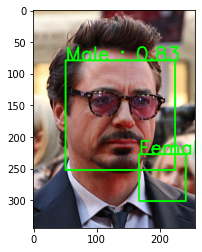

In [6]:
test_data_path = './data/robert.jpg'
color = 'bgr'
#read image
img = Image.open(test_data_path) # rgb
#convert into array
img = np.array(img)
#pass to pipeline model
img = pipeline_model(img)
plt.imshow(img)